### Import AIDC library and requirements

In [3]:
import aidc
import pandas as pd
import matplotlib.pyplot as plt
import io

### Load the dataset from the csv file and create AIDC model

In [4]:
df = pd.read_csv("../data/credit_human_ml.csv", sep=",",nrows=5500)

tbcs=aidc.create_table_case_source({ 'name': "initial" })
table = aidc.load_pandas_data(df)
taskmodel_data={
  'id': "0",
  'name': "taskModel",
  'description': "AIDC sample"
    }
taskmodel=aidc.create_task_model(taskmodel_data)
result = tbcs.build(table)
taskmodel.initFromBuiltCaseSource(tbcs, result)

### Analyze the model using default performance model

Warning, DefaultDispatchConfiguration.exportRootLevelStats is deprecated. Use Scenario.exportOverviewStats instead.

Warning, DefaultDispatchConfiguration.rootLevelStats is deprecated. Use Scenario.overviewStats instead.

Warning, DefaultDispatchConfiguration.exportRootCurveStats is deprecated. Use Scenario.exportOverviewStats instead.

Warning, DefaultDispatchConfiguration.exportRootLevelStats is deprecated. Use Scenario.exportOverviewStats instead.

Warning, DefaultDispatchConfiguration.rootLevelStats is deprecated. Use Scenario.overviewStats instead.



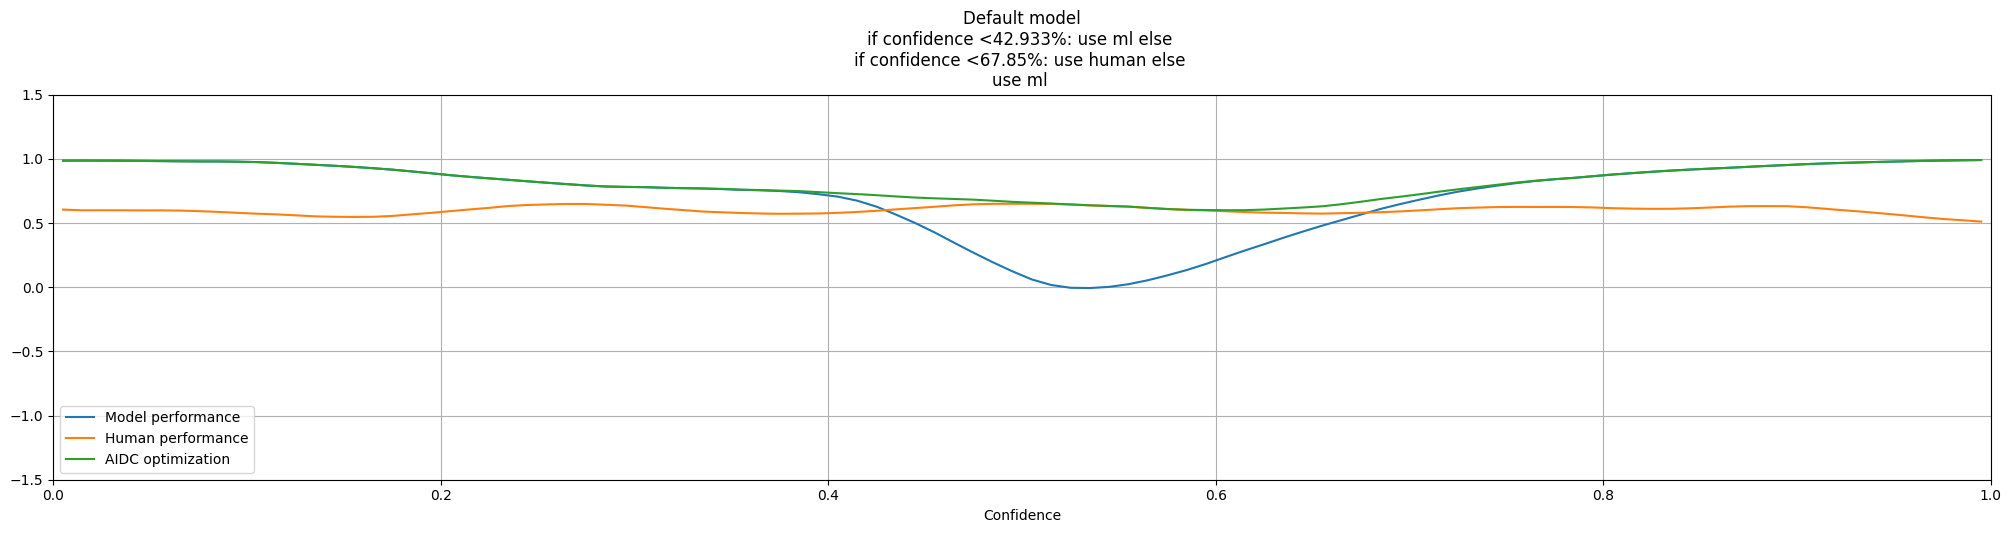

In [5]:
#Show default statistics
global_statistics = aidc.output_global_stats(taskmodel)
output_curves_data = aidc.output_curves(taskmodel)
performance = aidc.get_analyses(taskmodel)

scenario=taskmodel.getScenario()

params = {
    "indicator": "Performance",
    "attribute": taskmodel.defaultConfidenceProvider  
}

stats=scenario.overviewStats(taskmodel,params)
curves=scenario.exportOverviewStats(taskmodel,True,stats)

dispatch_description=aidc.dispatch_description(taskmodel)
        
global_statistics = aidc.output_global_stats(taskmodel)
performance = aidc.get_analyses(taskmodel)
    
df = pd.read_csv(io.StringIO(curves),sep='\t')
min_values=df.min()
max_values=df.max()
margin_factor=1.5
min_performance=min(min_values[df.columns[df.columns.str.contains('performance')]])
if -1 < min_performance < 1:
    min_performance = -1
max_performance=max(max_values[df.columns[df.columns.str.contains('performance')]])
if -1 < max_performance < 1:
    max_performance = 1
min_limit=min_performance * margin_factor
max_limit=max_performance * margin_factor
df.plot(title="Default model" +"\n" + dispatch_description ,xlabel="Confidence",x="Unnamed: 0",y=["ml weighted average performance","human weighted average performance","initial scenario weighted average performance"],ylim=[min_limit,max_limit],xlim=[0,1],figsize=(25, 5),grid=True)
plt.legend(["Model performance", "Human performance", "AIDC optimization"])
plt.show() 

### Analyze the model using custom performance model

Warning, DefaultDispatchConfiguration.exportRootLevelStats is deprecated. Use Scenario.exportOverviewStats instead.

Warning, DefaultDispatchConfiguration.rootLevelStats is deprecated. Use Scenario.overviewStats instead.



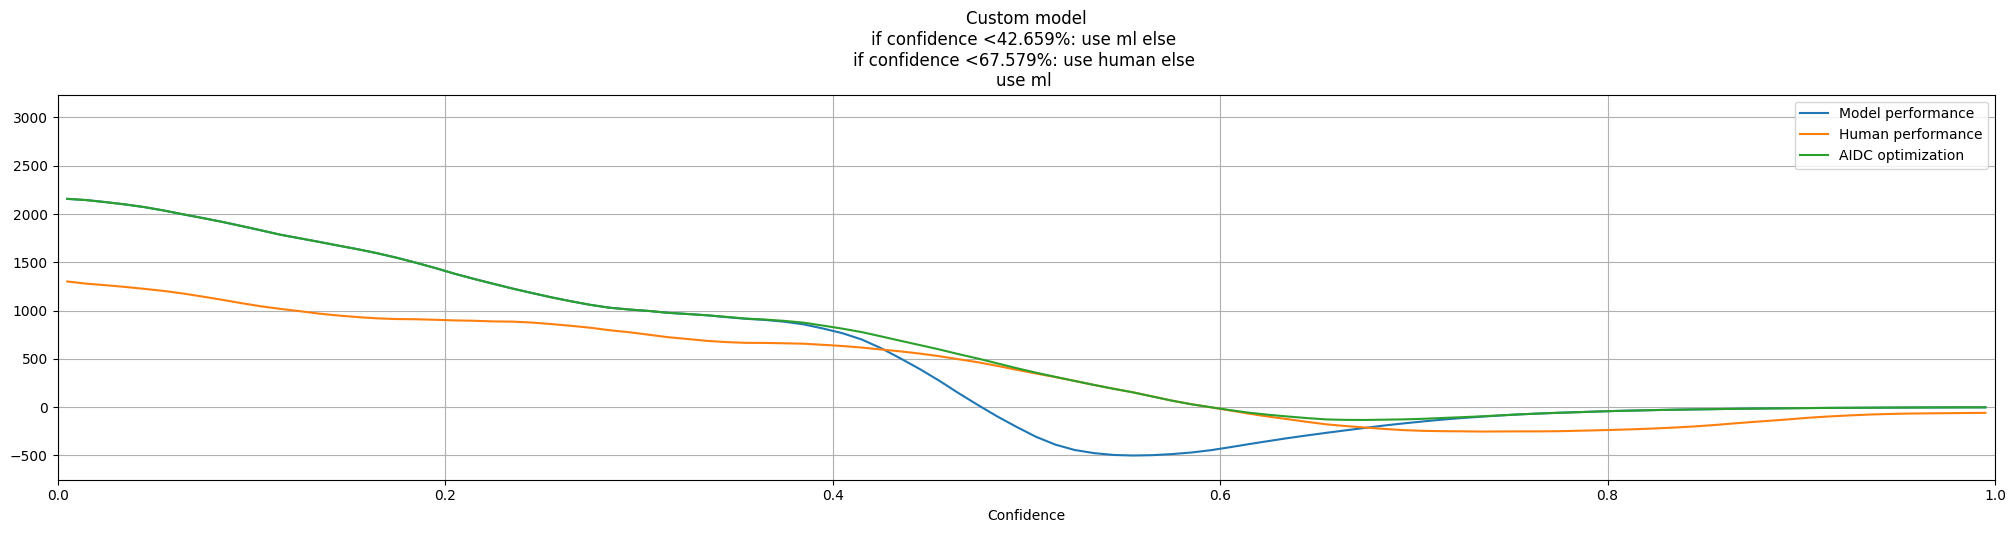

In [6]:
#Configure performance model
######################## Edit the values for your custom performance model. ############################
TruePositiveCost = "0"
FalsePositiveCost = "-LoanAmount*0.3"
FalseNegativeCost = "-LoanAmount*0.5"
TrueNegativeCost = "LoanAmount*0.3"
ModelDecisionCost = "-0.02"
HumanDecisionCost = "-0.05"
#################################################################################################

aidc.set_custom_indicators(taskmodel, TruePositiveCost, FalsePositiveCost, FalseNegativeCost, TrueNegativeCost, ModelDecisionCost, HumanDecisionCost)
scenario=taskmodel.getScenario()

params = {
    "indicator": "Performance",
    "attribute": taskmodel.defaultConfidenceProvider  
}

stats=scenario.overviewStats(taskmodel,params)
curves=scenario.exportOverviewStats(taskmodel,True,stats)

dispatch_description=aidc.dispatch_description(taskmodel)
        
global_statistics = aidc.output_global_stats(taskmodel)
performance = aidc.get_analyses(taskmodel)
    
df = pd.read_csv(io.StringIO(curves),sep='\t')
min_values=df.min()
max_values=df.max()
margin_factor=1.5
min_performance=min(min_values[df.columns[df.columns.str.contains('performance')]])
if -1 < min_performance < 1:
    min_performance = -1
max_performance=max(max_values[df.columns[df.columns.str.contains('performance')]])
if -1 < max_performance < 1:
    max_performance = 1
min_limit=min_performance * margin_factor
max_limit=max_performance * margin_factor
df.plot(title="Custom model" +"\n" + dispatch_description ,xlabel="Confidence",x="Unnamed: 0",y=["ml weighted average performance","human weighted average performance","initial scenario weighted average performance"],ylim=[min_limit,max_limit],xlim=[0,1],figsize=(25, 5),grid=True)
plt.legend(["Model performance", "Human performance", "AIDC optimization"])
plt.show() 

### Calculate the improvements introduced by using AI

Total improvement:  958975  over  4864  operations


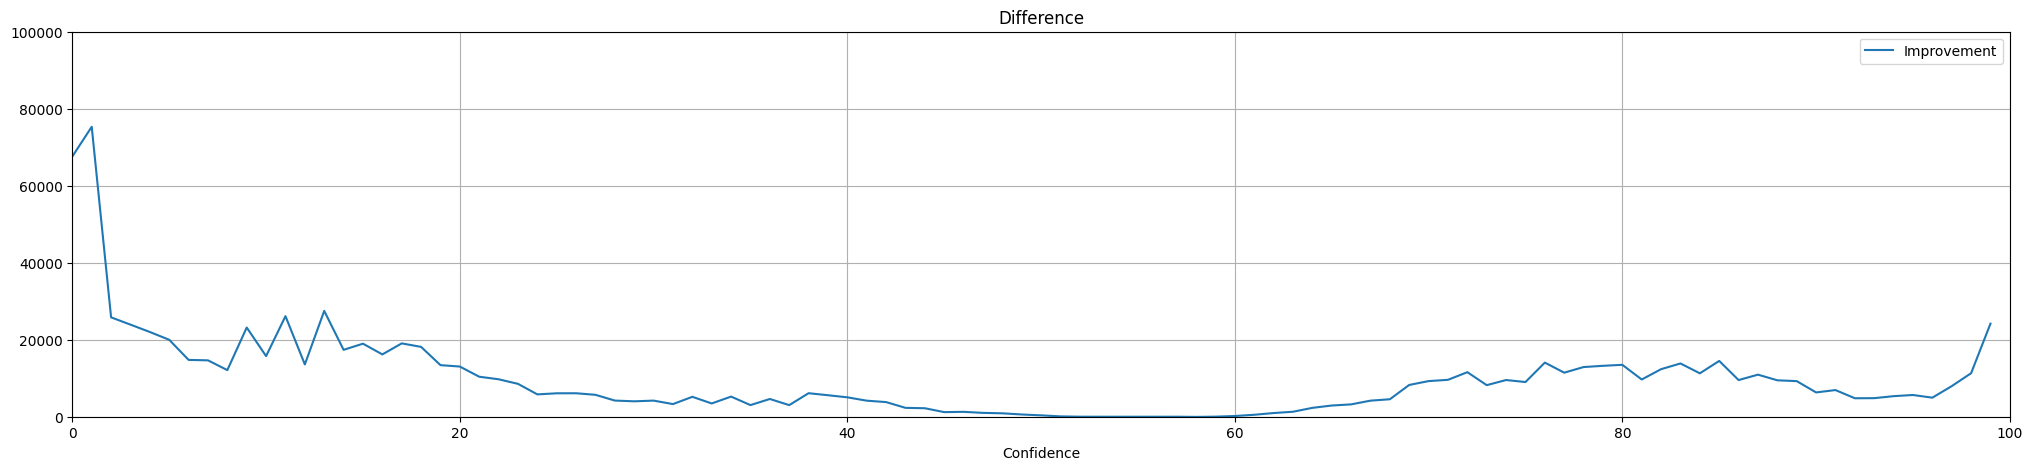

In [7]:
headerLabels= stats['curves'][scenario.selectedConfiguration]['headerLabels'].valueOf()
countColumn=headerLabels.index('count')
valueColumn=headerLabels.index('weightedAverage')

human_tool=""
for tool in (taskmodel['decisionTools']):
    if(taskmodel['decisionTools'][tool]['hasHuman'] == True):
        human_tool=tool
        
count_values=[]
human_values=[]
aidc_values=[]
human_total=[]
aidc_total=[]
difference_total=[]
for i in range(100):
    count_values.append(stats['curves'][scenario.selectedConfiguration]['content'][i][countColumn])
    human_values.append(stats['curves'][human_tool]['content'][i][valueColumn])
    aidc_values.append(stats['curves'][scenario.selectedConfiguration]['content'][i][valueColumn])
    human_total.append(count_values[i]*human_values[i])
    aidc_total.append(count_values[i]*aidc_values[i])
    difference_total.append(aidc_total[i]-human_total[i])
    

data={'Count':count_values,'Human':human_values,'AIDC':aidc_values,'Human Total':human_total,"AIDC Total":aidc_total,"Improvement":difference_total}
df = pd.DataFrame(data)

print("Total improvement: " , round(df['Improvement'].sum()), " over ", df['Count'].sum(), " operations")
df.plot(title='Difference',xlabel="Confidence" ,y=["Improvement"],ylim=[0,100000],xlim=[0,100],figsize=(25, 5),grid=True)
plt.show() 

### Export the AIDC model as JSON

In [9]:
## Export the most optimal model to JSON
import json
model_export=aidc.export_model(taskmodel)

json_object=json.dumps(model_export.valueOf(),indent=4).encode('utf-8')
## Save the most optimal AIDC rules
with open("AIDC.json", "w") as outfile:
    outfile.write(json_object)


b'{"id": "0", "name": "taskModel", "caseDataModel": {"id": "CaseDataModel0", "comments": [], "attributes": {"CheckingStatus": {"name": "CheckingStatus", "isUsable": true, "type": "categorical", "range": [], "values": {"0_to_200": {"name": "0_to_200", "_className": "AttributeValue", "_version": 1}, "less_0": {"name": "less_0", "_className": "AttributeValue", "_version": 1}, "no_checking": {"name": "no_checking", "_className": "AttributeValue", "_version": 1}, "greater_200": {"name": "greater_200", "_className": "AttributeValue", "_version": 1}}, "_className": "Attribute", "_version": 1}, "LoanDuration": {"name": "LoanDuration", "isUsable": true, "type": "continuous", "range": [4, 64], "values": {}, "_className": "Attribute", "_version": 1}, "CreditHistory": {"name": "CreditHistory", "isUsable": true, "type": "categorical", "range": [], "values": {"credits_paid_to_date": {"name": "credits_paid_to_date", "_className": "AttributeValue", "_version": 1}, "prior_payments_delayed": {"name": "p